In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm

In [2]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = False
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

In [3]:
generate_data = True
directory = "/hpcwork/zu992399/look_elsewhere/distance_test/"

bins = 5
bins_edge = 2
N = 10000
N_tests = 100000

# Generate Data

In [4]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_binomial(N_data, N_BT, N_total):
    p_value = 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)
    p_left = stats.binom.cdf(N_data, N_total, N_BT/N_total) 
    return np.min(np.array([p_value, p_left]), axis=0)*2
    #return p_value

In [11]:
BH_percentiles = [1e-1, 1e-2, 1e-3, 1e-4]
fixed_cut = [0.51, 0.53, 0.55]

def calc_and_apply_threshold(samples_preds, data_preds, efficiency):
    """
    Returns number of samples and data events before and after cut

    Apply quantile cut based on efficiency to samples classifier scores and then the
    same threshold to data classifier scores 
    """
    eps = np.quantile(samples_preds, 1-efficiency, method="nearest")
    if efficiency == 1:
        eps=0.
    N_samples_after = np.size(np.where(samples_preds>eps))
    N_samples = len(samples_preds)
    N_after = np.size(np.where(data_preds>eps))
    N = len(data_preds)
    return N_samples_after, N_samples, N_after, N

def calc_and_apply_threshold(samples_preds, data_preds, efficiency):
    """
    Optimized version.

    - If `efficiency` is a scalar -> returns tuple (N_samples_after, N_samples, N_after, N).
    - If `efficiency` is array-like -> returns four 1D numpy arrays in the same order,
      each of shape (len(efficiency),), containing integer counts for each efficiency.

    Notes:
    - Maintains the original special-case behavior: if efficiency == 1, threshold eps is set to 0.
      (Uses np.isclose to handle floating point.)
    - Uses boolean counts instead of np.where(...)/np.size for speed.
    """
    samples = np.asarray(samples_preds).ravel()
    data = np.asarray(data_preds).ravel()

    # handle scalar efficiency
    if np.isscalar(efficiency):
        eff = float(efficiency)
        if np.isclose(eff, 1.0):
            eps = 0.0
        else:
            q = 1.0 - eff
            eps = np.quantile(samples, q)
        n_samples_after = int(np.count_nonzero(samples > eps))
        n_samples = samples.size
        n_after = int(np.count_nonzero(data > eps))
        n = data.size
        return n_samples_after, n_samples, n_after, n

    effs = np.asarray(efficiency, dtype=float)
    eps_arr = np.quantile(samples, 1,0-effs)
    eps_arr[np.isclose(effs, 1.0)] = 0.0

    samples_gt = (samples[:, None] > eps_arr[None, :]).sum(axis=0).astype(int)
    data_gt = (data[:, None] > eps_arr[None, :]).sum(axis=0).astype(int)

    n_samples_arr = np.full(effs.shape, samples.size, dtype=int)
    n_arr = np.full(effs.shape, data.size, dtype=int)

    return samples_gt, n_samples_arr, data_gt, n_arr


class distance_classifier:
    def __init__(self, data_binned, BT_binned, bin_edges, r=1/3.):
        values = (data_binned - r*BT_binned)/np.sqrt(r**2*BT_binned+data_binned)
        best_bin = np.unravel_index(np.argmax(values), values.shape)
        self.x_best = (bin_edges[0][best_bin[0]]+bin_edges[0][best_bin[0]+1])/2
        self.y_best = (bin_edges[1][best_bin[1]]+bin_edges[1][best_bin[1]+1])/2

    def predict(self, data):
        x = data[:,0]
        y = data[:,1]
        return -((x-self.x_best)**2 + (y-self.y_best)**2) 

def p_values_from_folder(data_tuple, save_folder, save_file, remove_0s=True):
    N_samples_after = data_tuple[0]
    N_samples = data_tuple[1]
    N_after = data_tuple[2]
    N = data_tuple[3]
    p = []
    for i in range(len(N[0])):
        if remove_0s:
            inds = np.nonzero(N_samples_after[:,i])[0]
            inds2 = np.nonzero(N_after[inds,i])[0]
            p.append(np.sort(p_value_poissonpoisson(N_after[inds,i][inds2], N_samples_after[inds,i][inds2]/N_samples[inds,i][inds2]*N[inds,i][inds2])))
        else: 
            p.append(np.sort(p_value_poissonpoisson(N_after[:,i], N_samples_after[:,i]/N_samples[:,i]*N[:,i])))
    np.save(save_folder+save_file, np.array(p))

def oned_sample(N, rv):
    x = rv.rvs(N).reshape((N,1))
    y = rv.rvs(N).reshape((N,1))
    return np.concatenate((x,y), axis=1)

In [32]:
if generate_data:
    def do_test_val(N_tests, bins, N, bins_edge = None, uniform=True):
        rv = multivariate_normal([0,0], [[1,0],[0,1]])        
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-bins_edge,bins_edge,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

        if uniform: 
            rv = stats.uniform(loc=-bins_edge, scale=2*bins_edge)

        arr_shape = (N_tests,len(BH_percentiles))
        N_samples_after_train = np.zeros(arr_shape)
        N_samples_train = np.zeros(arr_shape)
        N_after_train = np.zeros(arr_shape)
        N_train = np.zeros(arr_shape)

        N_samples_after_test = np.zeros(arr_shape)
        N_samples_test = np.zeros(arr_shape)
        N_after_test = np.zeros(arr_shape)
        N_test = np.zeros(arr_shape)

        for k in tqdm.tqdm(range(N_tests)):
            if uniform: 
                data_train = oned_sample(N, rv)
                BT_train = oned_sample(N, rv)  
            else:
                data_train = rv.rvs(size=N, random_state=k)
                BT_train = rv.rvs(size=N, random_state=k+N_tests)
            
            data_binned = np.histogramdd(data_train, bins=edges)[0]
            BT_binned = np.histogramdd(BT_train, bins=edges)[0]
            model = distance_classifier(data_binned, BT_binned, edges)

            if uniform:
                data_test = oned_sample(N, rv)
                BT_test = oned_sample(N, rv)
            else:  
                data_test = rv.rvs(size=N, random_state=k+2*N_tests)
                BT_test = rv.rvs(size=N, random_state=k+3*N_tests)
            for j, perc in enumerate(BH_percentiles):
                N_samples_after_train[k,j], N_samples_train[k,j], N_after_train[k,j], N_train[k,j] = calc_and_apply_threshold(model.predict(BT_train), model.predict(data_train), perc)
                N_samples_after_test[k,j], N_samples_test[k,j], N_after_test[k,j], N_test[k,j] = calc_and_apply_threshold(model.predict(BT_test), model.predict(data_test), perc)

        p_values_from_folder((N_samples_after_train, N_samples_train, N_after_train, N_train), directory, "p_train.npy")
        p_values_from_folder((N_samples_after_test, N_samples_test, N_after_test, N_test), directory, "p_test.npy")

    do_test_val(N_tests, bins, N, bins_edge=bins_edge)

100%|██████████| 100000/100000 [04:37<00:00, 359.87it/s]
/tmp/zu992399/login23-3_1228162/ipykernel_1817086/694914494.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(save_folder+save_file, np.array(p))


In [12]:
if generate_data:
    def do_test_kfold(N_tests, bins, N, name, bins_edge = None, uniform=True, folds=5):
        print(N)
        rv = multivariate_normal([0,0], [[1,0],[0,1]])        
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-bins_edge,bins_edge,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

        if uniform: 
            rv = stats.uniform(loc=-bins_edge, scale=2*bins_edge)
        arr_shape = (folds, N_tests,len(BH_percentiles))

        N_samples_after_test = np.zeros(arr_shape)
        N_samples_test = np.zeros(arr_shape)
        N_after_test = np.zeros(arr_shape)
        N_test = np.zeros(arr_shape)

        for k in tqdm.tqdm(range(N_tests)):
            if uniform: 
                data = oned_sample(N, rv)
                BT = oned_sample(N, rv)  
            else:
                data = rv.rvs(size=N, random_state=k)
                BT = rv.rvs(size=N, random_state=k+N_tests)
            data = np.array_split(data, folds)
            BT = np.array_split(BT, folds)

            data_hist = np.zeros((bins,bins, folds))
            BT_hist = np.zeros((bins,bins, folds))
            for m in range(folds):
                data_hist[:,:,m] = np.histogramdd(data[m], bins=edges)[0]
                BT_hist[:,:,m] = np.histogramdd(BT[m], bins=edges)[0]

            for fold in range(folds):
                inds = np.roll(np.array(range(folds)), fold)
                model = distance_classifier(np.sum(data_hist[:,:,:-1],axis=-1), np.sum(BT_hist[:,:,:-1],axis=-1), edges)

                for j, perc in enumerate(BH_percentiles):
                    N_samples_after_test[fold, k,j], N_samples_test[fold, k,j], N_after_test[fold, k,j], N_test[fold, k,j] = calc_and_apply_threshold(model.predict(BT[inds[-1]]), model.predict(data[inds[-1]]), perc)
        
        
        
        #p_values_from_folder((N_samples_after_train, N_samples_train, N_after_train, N_train), directory, "p_train.npy")
        p_values_from_folder((np.sum(N_samples_after_test, axis=0),np.sum(N_samples_test, axis=0), np.sum(N_after_test,axis=0), np.sum(N_test,axis=0)), directory, "p_kfold_"+name+".npy")

    do_test_kfold(N_tests, bins, N, "test_uniform", bins_edge=bins_edge)
    do_test_kfold(N_tests, bins, N, "test_gaussian", bins_edge=bins_edge, uniform=False)


10000


  2%|▏         | 1662/100000 [00:05<05:53, 278.28it/s]


KeyboardInterrupt: 

In [13]:
if generate_data:
    def do_test_kfold(N_tests, bins, N, name, bins_edge=2, uniform=True, folds=5):
        rng_global = np.random.default_rng()

        edges = [np.linspace(-bins_edge, bins_edge, bins+1),
                    np.linspace(-bins_edge, bins_edge, bins+1)]

        # Ergebnisarrays: (folds, N_tests, n_percentiles)
        n_perc = len(BH_percentiles)
        arr_shape = (folds, N_tests, n_perc)
        N_samples_after_test = np.zeros(arr_shape, dtype=float)
        N_samples_test = np.zeros(arr_shape, dtype=float)
        N_after_test = np.zeros(arr_shape, dtype=float)
        N_test = np.zeros(arr_shape, dtype=float)

        for k in tqdm.tqdm(range(N_tests), desc="tests"):
            # Erzeuge Daten für diesen Test
            if uniform:
                # gleichverteilte Punkte im Quadrat [-bins_edge, bins_edge]^2
                data = rng_global.uniform(-bins_edge, bins_edge, size=(N, 2))
                BT = rng_global.uniform(-bins_edge, bins_edge, size=(N, 2))
            else:
                # deterministische Seeds pro Test für Reproduzierbarkeit
                data = np.random.default_rng(k).multivariate_normal([0,0], [[1,0],[0,1]], size=N)
                BT = np.random.default_rng(k + N_tests).multivariate_normal([0,0], [[1,0],[0,1]], size=N)

            # Indizes in Folds (vermeidet unnötige Kopien, falls N nicht teilbar ist -> array_split wie vorher)
            idx_splits = np.array_split(np.arange(N), folds)
            # Listen von Fold-Daten (einfacher Zugriff)
            data_folds = [data[idx] for idx in idx_splits]
            BT_folds = [BT[idx] for idx in idx_splits]

            # Berechne Histogramme pro Fold (fold, bins, bins)
            # np.histogram2d gibt H mit shape (bins, bins)
            data_hist = np.empty((folds, bins, bins), dtype=int)
            BT_hist = np.empty((folds, bins, bins), dtype=int)
            for m in range(folds):
                if data_folds[m].size > 0:
                    H, _, _ = np.histogram2d(data_folds[m][:,0], data_folds[m][:,1], bins=edges)
                    data_hist[m] = H.astype(int)
                else:
                    data_hist[m] = 0
                if BT_folds[m].size > 0:
                    Hbt, _, _ = np.histogram2d(BT_folds[m][:,0], BT_folds[m][:,1], bins=edges)
                    BT_hist[m] = Hbt.astype(int)
                else:
                    BT_hist[m] = 0

            # Totale Histogramme (Training = total - fold_hist)
            total_data_hist = data_hist.sum(axis=0)
            total_BT_hist = BT_hist.sum(axis=0)

            # Für jeden Fold: trainiere/erzeuge Model nur mit train_hist (total - fold)
            for fold in range(folds):
                train_data_hist = total_data_hist - data_hist[fold]
                train_BT_hist = total_BT_hist - BT_hist[fold]

                # distance_classifier erwartet offenbar (data_train_hist, BT_train_hist, edges)
                model = distance_classifier(train_data_hist, train_BT_hist, edges)

                # Predictions nur einmal pro Fold berechnen
                pred_BT = model.predict(BT_folds[fold])
                pred_data = model.predict(data_folds[fold])

                # Für alle BH_percentiles die Schwellen anwenden
                for j, perc in enumerate(BH_percentiles):
                    out = calc_and_apply_threshold(pred_BT, pred_data, perc)
                    # out sollte ein Tupel (N_samples_after_test, N_samples_test, N_after_test, N_test)
                    N_samples_after_test[fold, k, j], N_samples_test[fold, k, j], \
                    N_after_test[fold, k, j], N_test[fold, k, j] = out

        
        p_values_from_folder((np.sum(N_samples_after_test, axis=0),np.sum(N_samples_test, axis=0), np.sum(N_after_test,axis=0), np.sum(N_test,axis=0)), directory, "p_kfold_"+name+".npy")
        
        
    do_test_kfold(N_tests, bins, N, "test_uniform", bins_edge=bins_edge)
    do_test_kfold(N_tests, bins, N, "test_gaussian", bins_edge=bins_edge, uniform=False)


tests:   1%|          | 1131/100000 [00:03<05:32, 297.63it/s]


KeyboardInterrupt: 

# Plot results

In [4]:
colors=["green", "blue", "red"]#, "orange"]
labels=[r"$10^{-1}$",r"$10^{-2}$"]#, r"$10^{-4}$"]
def plot_array(ax, p_values):
    for i in range(len(labels)):
        ax.plot(np.arange(1, len(p_values[i])+1)/len(p_values[i]), p_values[i], colors[i], label=labels[i])

def plot_histogram(ax, p_values, bins):
    for i in range(len(labels)):
        y, _, _ = ax.hist(p_values[i], bins=bins, histtype="step", color=colors[i], label=labels[i], density=True)

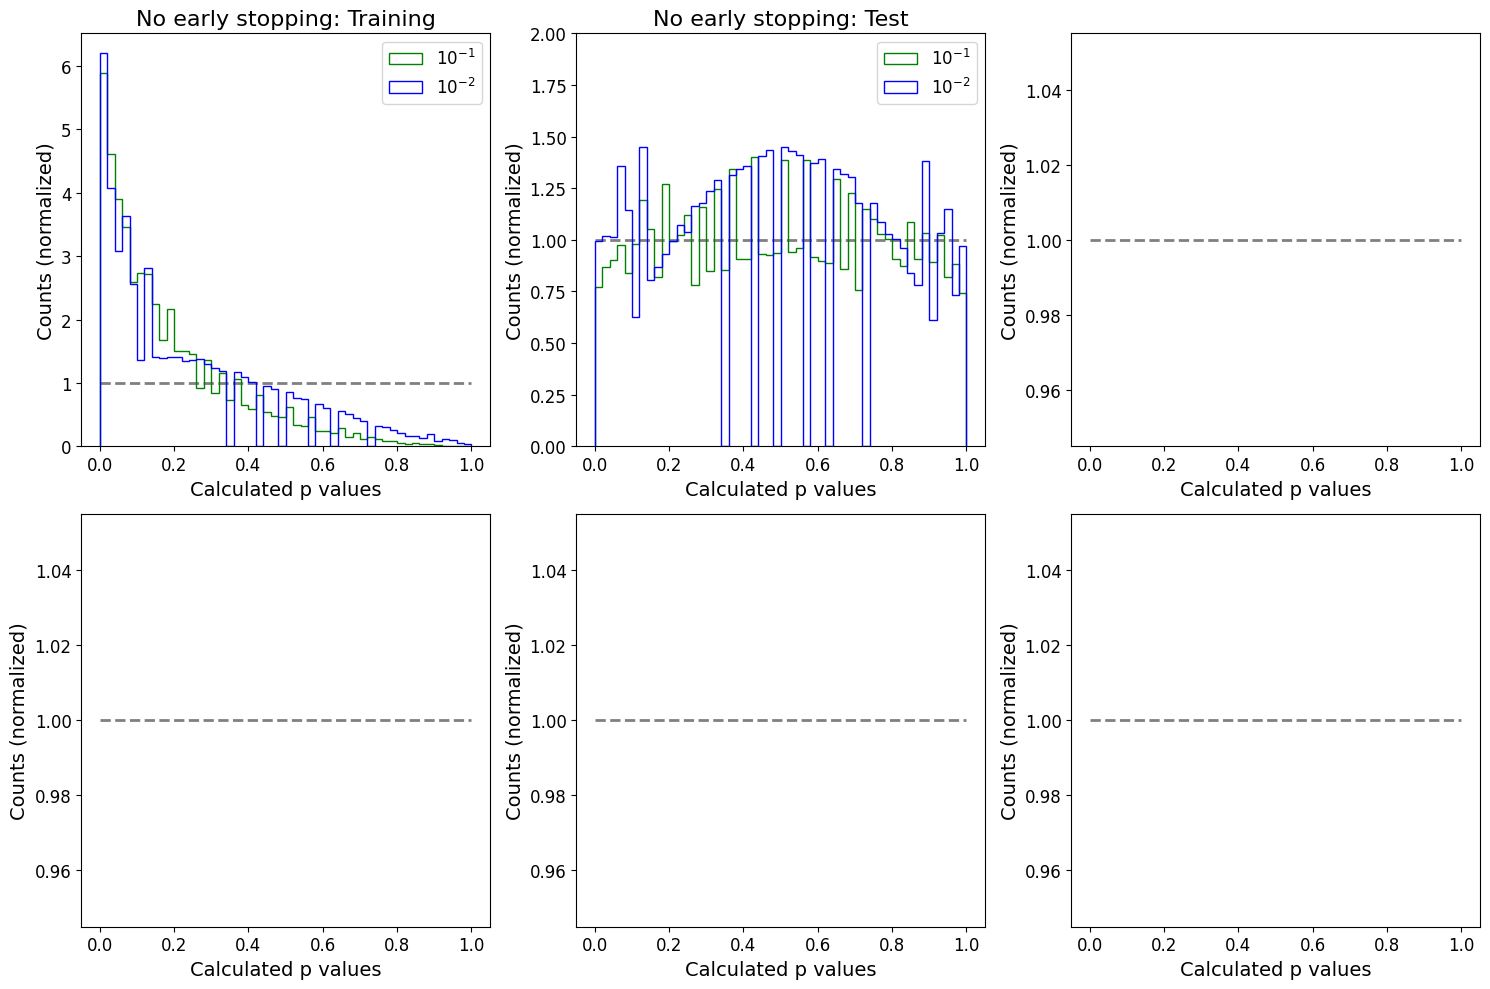

In [5]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=np.linspace(0,1,51)
bins_center = 0.5*(bins_plot[1:]+bins_plot[:-1])

p_train = np.load(directory+"p_train.npy",allow_pickle=True)
p_test = np.load(directory+"p_test.npy",allow_pickle=True)

for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")


plot_histogram(ax[0], p_train, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("No early stopping: Training")
ax[0].legend(loc="upper right")

plot_histogram(ax[1], p_test, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("No early stopping: Test")
ax[1].set_ylim(0,2)
ax[1].legend(loc="upper right")
"""

plot_histogram(ax[2], p_earlystopping_splittrain, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[2].set_title("Early stopping: Training")
ax[2].legend(loc="upper right")

plot_histogram(ax[3], p_earlystopping_splitval, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[3].set_title("Early stopping: Validation")
#ax[3].set_ylim(0,2)
ax[3].legend(loc="upper right")

plot_histogram(ax[4], p_earlystopping_train, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[4].set_title("Early stopping: Training + Validation")
ax[4].set_ylim(0,2)
ax[4].legend(loc="upper right")

plot_histogram(ax[5], p_earlystopping_test, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[5].set_title("Early stopping: Test")
ax[5].set_ylim(0,2)
ax[5].legend(loc="upper right")"""

fig.tight_layout()
fig.savefig("plots/distance_histograms.pdf")

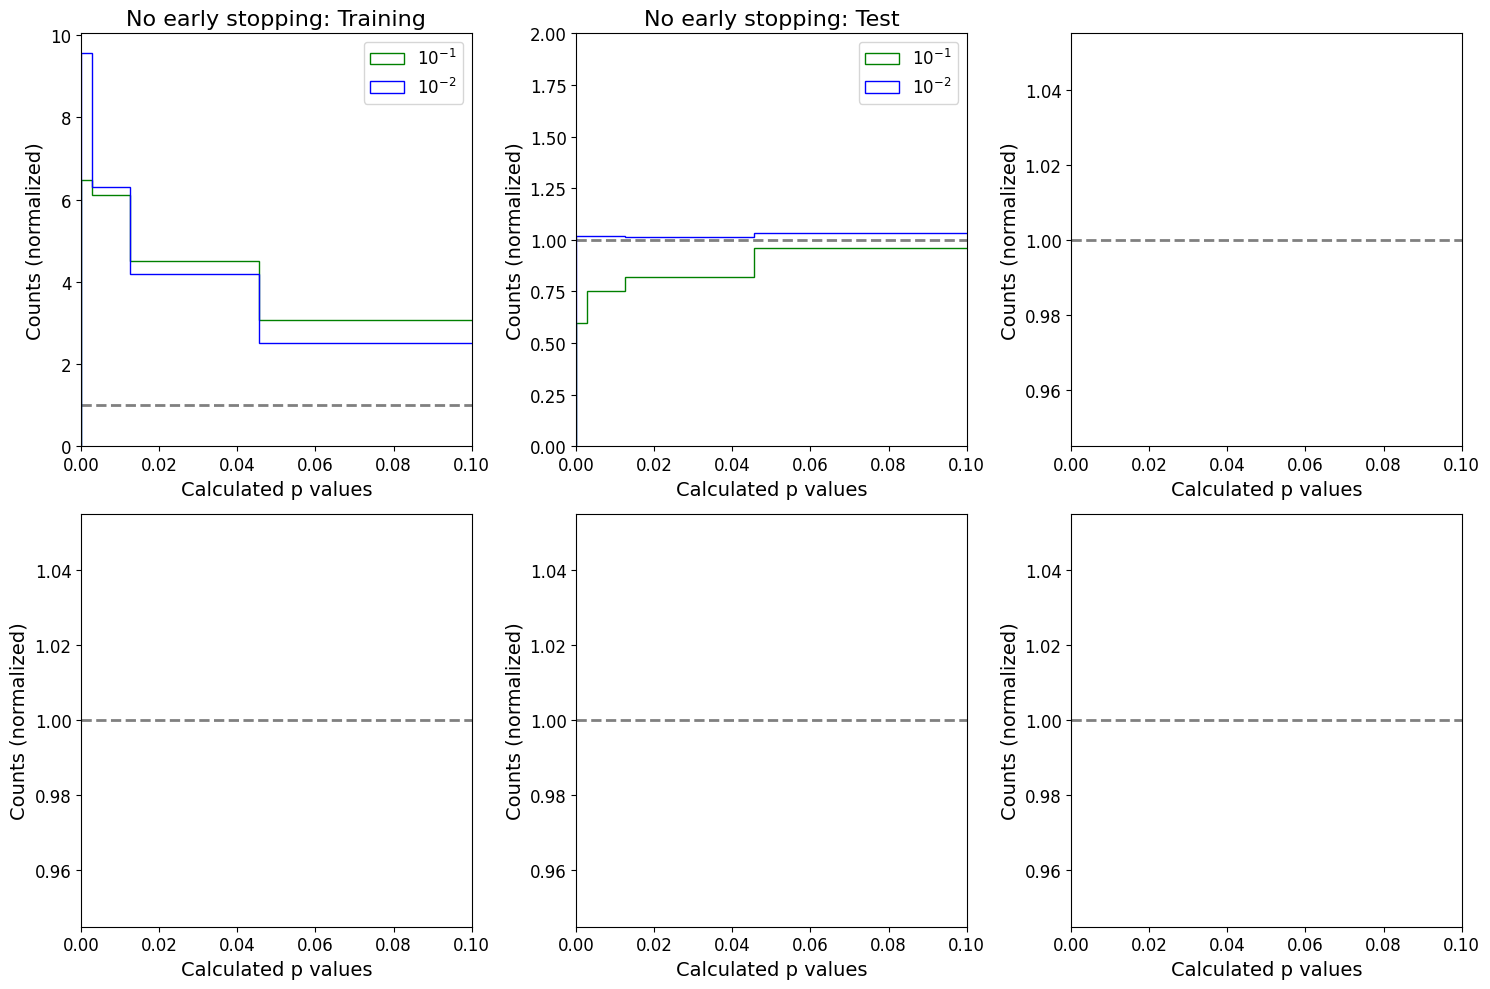

In [10]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]

p_train = np.load(directory+"p_train.npy",allow_pickle=True)
p_test = np.load(directory+"p_test.npy",allow_pickle=True)
for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")


plot_histogram(ax[0], p_train, bins_plot)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("No early stopping: Training")
ax[0].legend(loc="upper right")

plot_histogram(ax[1], p_test, bins_plot)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("No early stopping: Test")
ax[1].set_ylim(0,2)
ax[1].legend(loc="upper right")


"""plot_histogram(ax[2], p_earlystopping_splittrain, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[2].set_title("Early stopping: Training")
ax[2].legend(loc="upper right")

plot_histogram(ax[3], p_earlystopping_splitval, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[3].set_title("Early stopping: Validation")
#ax[3].set_ylim(0,2)
ax[3].legend(loc="upper right")

plot_histogram(ax[4], p_earlystopping_train, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[4].set_title("Early stopping: Validation + Training")
ax[4].set_ylim(0,2)
ax[4].legend(loc="upper right")

plot_histogram(ax[5], p_earlystopping_test, bins_plot)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[5].set_title("Early stopping: Test")
ax[5].set_ylim(0,2)
ax[5].legend(loc="upper right")"""


for i in range(len(ax)):
    ax[i].set_xlim(0,0.1)

fig.tight_layout()
fig.savefig("plots/distance_histograms_sigmas.pdf")

/tmp/zu992399/login23-3_1228162/ipykernel_1929474/2594067192.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[1].set_ylim(0,2)


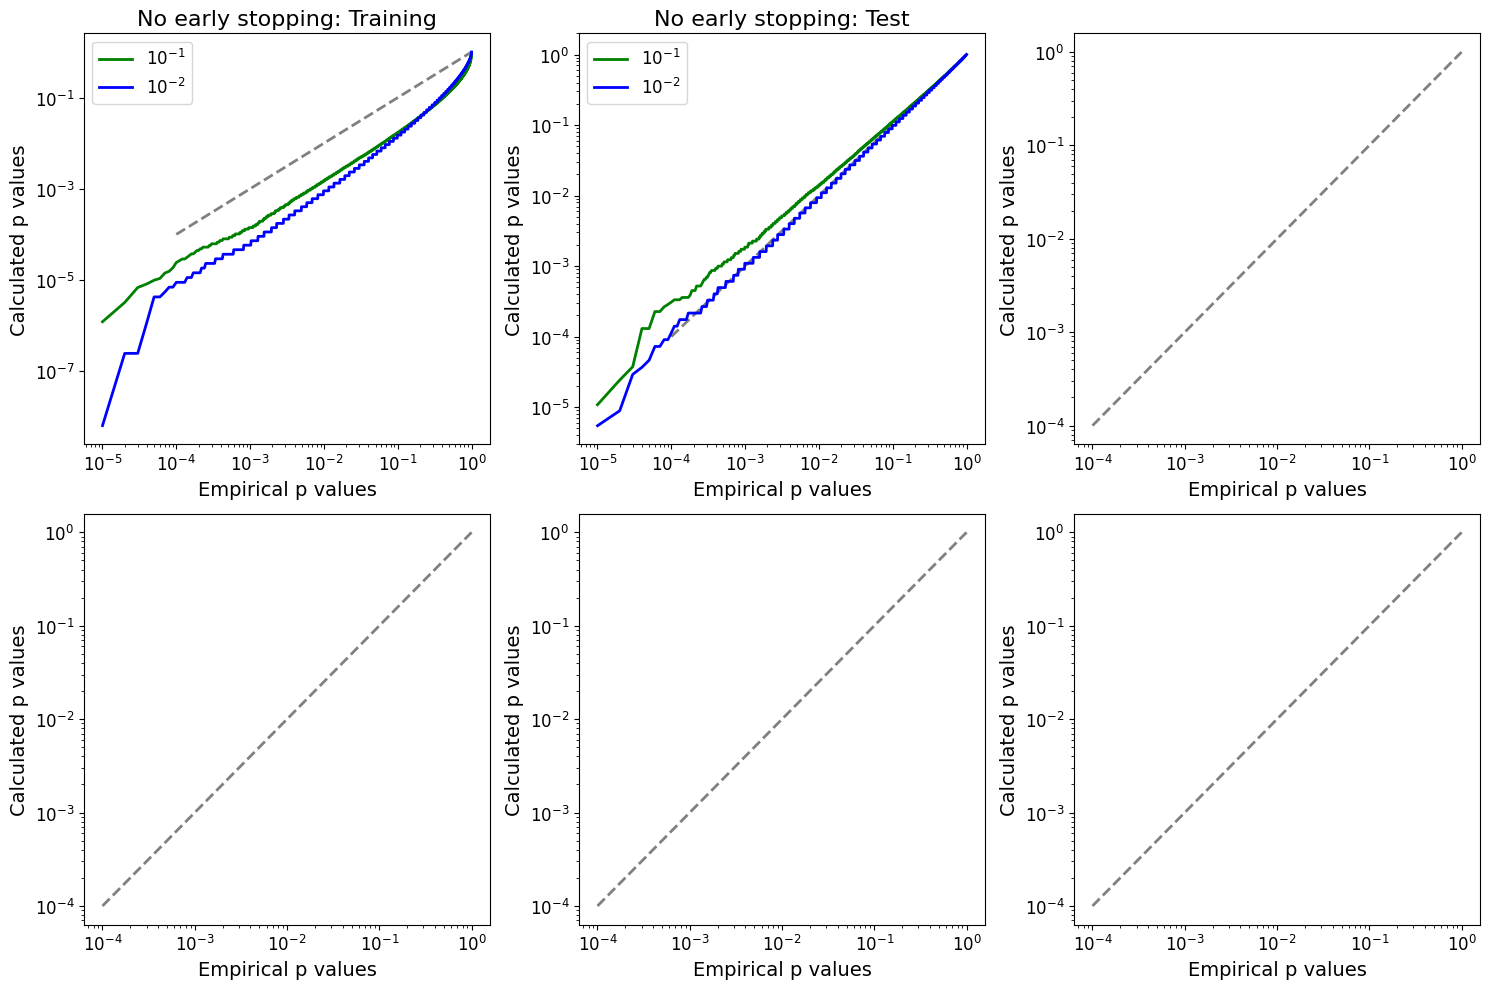

In [11]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()


p_train = np.load(directory+"p_train.npy",allow_pickle=True)
p_test = np.load(directory+"p_test.npy",allow_pickle=True)


for i in range(len(ax)):
    ax[i].set_xlabel("Empirical p values")
    ax[i].set_ylabel("Calculated p values")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot([1e-4, 1], [1e-4, 1], color="grey", linestyle="dashed")


plot_array(ax[0], p_train)
#y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("No early stopping: Training")
ax[0].legend(loc="upper left")

plot_array(ax[1], p_test)
#y,_, _ = ax[1].hist(p_values_test, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("No early stopping: Test")
ax[1].set_ylim(0,2)
ax[1].legend(loc="upper left")
"""

plot_array(ax[2], p_earlystopping_splittrain)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[2].set_title("Early stopping: Training")
ax[2].legend(loc="upper left")

plot_array(ax[3], p_earlystopping_splitval)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[3].set_title("Early stopping: Validation")
#ax[3].set_ylim(0,2)
ax[3].legend(loc="upper left")

plot_array(ax[4], p_earlystopping_train)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[4].set_title("Early stopping: Training + Validation")
ax[4].legend(loc="upper left")

plot_array(ax[5], p_earlystopping_test)
#ax[2].hist((p_values_val_on_train), bins=bins_plot, histtype="step", color=("black"), label=("Train"), density=True)
ax[5].set_title("Early stopping: Test")
ax[5].legend(loc="upper left")
"""
fig.tight_layout()
fig.savefig("plots/distance_cumulative.pdf")

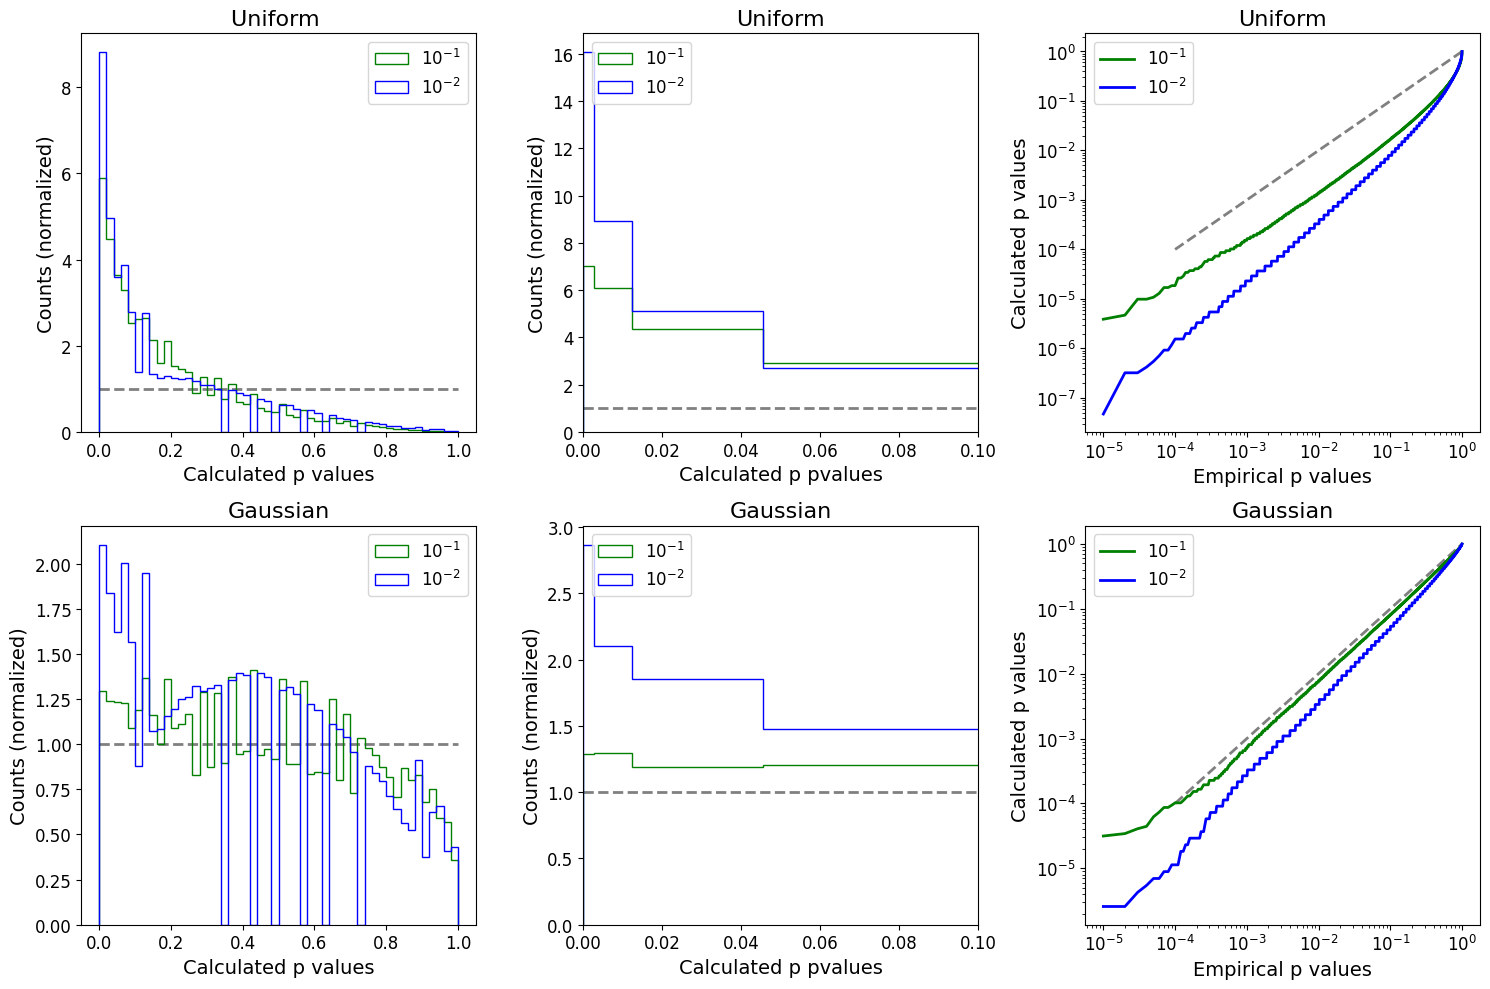

In [8]:
p_uniform = np.load(directory+"p_kfold_test_uniform.npy", allow_pickle=True)
p_gaussian = np.load(directory+"p_kfold_test_gaussian.npy", allow_pickle=True)
#p_noearly = np.load(directory+"p_values_kfolds_noearlystopping.npy", allow_pickle=True)

fig, ax = plt.subplots(2,3, figsize=(15,10))
bins_plot=np.linspace(0,1,51)

for i in range(2):
    ax[i,0].set_xlabel("Calculated p values")
    ax[i,0].set_ylabel("Counts (normalized)")
    ax[i,0].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,1].set_xlabel("Calculated p pvalues")
    ax[i,1].set_ylabel("Counts (normalized)")
    ax[i,1].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,2].set_xlabel("Empirical p values")
    ax[i,2].set_ylabel("Calculated p values")
    ax[i,2].set_xscale("log")
    ax[i,2].set_yscale("log")
    ax[i,2].plot([1e-4, 1], [1e-4, 1], color="grey", linestyle="dashed")

plot_histogram(ax[0,0], p_uniform, bins_plot)
ax[0,0].set_title("Uniform ")
ax[0,0].legend(loc="upper right")
#ax[1,0].set_ylim(0,2)

plot_histogram(ax[1,0], p_gaussian, bins_plot)
ax[1,0].set_title("Gaussian")
ax[1,0].legend(loc="upper right")

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
plot_histogram(ax[0,1], p_uniform, bins_plot)
ax[0,1].set_title("Uniform")
ax[0,1].legend(loc="upper left")
ax[0,1].set_xlim(0,0.1)

plot_histogram(ax[1,1], p_gaussian, bins_plot)
ax[1,1].set_title("Gaussian")
ax[1,1].legend(loc="upper left")
ax[1,1].set_xlim(0,0.1)


plot_array(ax[0,2], p_uniform)
ax[0,2].set_title("Uniform")
ax[0,2].legend(loc="upper left")


plot_array(ax[1,2], p_gaussian)
ax[1,2].set_title("Gaussian")
ax[1,2].legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/distance_kfolds.pdf")

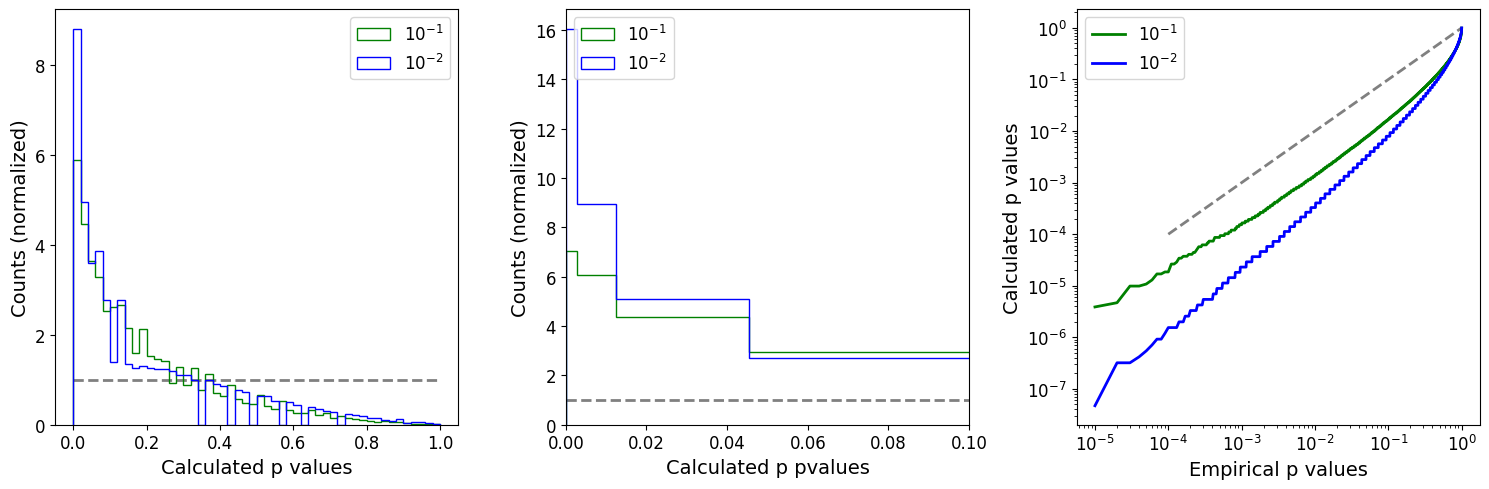

In [12]:
p_uniform = np.load(directory+"p_kfold_test_uniform.npy", allow_pickle=True)
p_gaussian = np.load(directory+"p_kfold_test_gaussian.npy", allow_pickle=True)
#p_noearly = np.load(directory+"p_values_kfolds_noearlystopping.npy", allow_pickle=True)

fig, ax = plt.subplots(1,3, figsize=(15,5))
bins_plot=np.linspace(0,1,51)
ax = ax.reshape((1,3))

for i in range(1):
    ax[i,0].set_xlabel("Calculated p values")
    ax[i,0].set_ylabel("Counts (normalized)")
    ax[i,0].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,1].set_xlabel("Calculated p pvalues")
    ax[i,1].set_ylabel("Counts (normalized)")
    ax[i,1].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,2].set_xlabel("Empirical p values")
    ax[i,2].set_ylabel("Calculated p values")
    ax[i,2].set_xscale("log")
    ax[i,2].set_yscale("log")
    ax[i,2].plot([1e-4, 1], [1e-4, 1], color="grey", linestyle="dashed")

plot_histogram(ax[0,0], p_uniform, bins_plot)

ax[0,0].legend(loc="upper right")
#ax[1,0].set_ylim(0,2)

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
plot_histogram(ax[0,1], p_uniform, bins_plot)
ax[0,1].legend(loc="upper left")
ax[0,1].set_xlim(0,0.1)

plot_array(ax[0,2], p_uniform)
ax[0,2].legend(loc="upper left")


fig.tight_layout()
fig.savefig("plots/distance_kfolds_uniformonly.pdf")